In [37]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import model_selection
from matplotlib.pylab import (
    figure,
    grid,
    legend,
    loglog,
    semilogx,
    subplot,
    title,
    xlabel,
    ylabel,
)
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.dummy import DummyRegressor
import torch
from dtuimldmtools import train_neural_net

from scipy.stats import ttest_rel

In [18]:
# Function for preprocessing
def preprocess_data(filepath):
    # Load dataset
    data = pd.read_csv(filepath)
    
    # Check for missing values and print counts
    print(f"Missing values in 'Age': {data['Age'].isna().sum()}")
    print(f"Missing values in 'Pclass': {data['Pclass'].isna().sum()}")
    print(f"Missing values in 'Sex': {data['Sex'].isna().sum()}")
    print(f"Missing values in 'Embarked': {data['Embarked'].isna().sum()}")
    print(f"Missing values in 'Parch': {data['Parch'].isna().sum()}")
    print(f"Missing values in 'SibSp': {data['SibSp'].isna().sum()}")
    print(f"Missing values in 'Fare': {data['Fare'].isna().sum()}")
    
    # Impute missing values
    age_imputer = SimpleImputer(strategy="median")
    data["Age"] = age_imputer.fit_transform(data[["Age"]])
    
    embarked_imputer = SimpleImputer(strategy="most_frequent")
    data["Embarked"] = embarked_imputer.fit_transform(data[["Embarked"]]).ravel()

    data['Fare'] = np.log1p(data['Fare'])

    # Drop irrelevant columns
    data = data.drop(columns=["PassengerId", "Name", "Ticket", "Cabin", "Survived"])
    
    # Encode categorical variables (keep all classes)
    data = pd.get_dummies(data, columns=["Sex", "Embarked"], drop_first=True)
    data = pd.get_dummies(data, columns=["Pclass"], drop_first=False)

    # Split features and target
    X = data.drop(columns=["Fare"])
    y = data["Fare"]

    # Store feature names before scaling
    feature_names = list(data.drop(columns=["Fare"]).columns)
    print("Feature Names:", feature_names)
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale numerical features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print("Preprocessing completed.")
    return X_train_scaled, X_test_scaled, y_train, y_test, feature_names

In [19]:
# Preprocess the data
X_train_scaled, X_test_scaled, y_train, y_test, feature_names = preprocess_data("titanic.csv")

# Define attribute names with intercept term
attributeNames = ["Intercept"] + feature_names
print("Attribute Names:", attributeNames)

Missing values in 'Age': 177
Missing values in 'Pclass': 0
Missing values in 'Sex': 0
Missing values in 'Embarked': 2
Missing values in 'Parch': 0
Missing values in 'SibSp': 0
Missing values in 'Fare': 0
Feature Names: ['Age', 'SibSp', 'Parch', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']
Preprocessing completed.
Attribute Names: ['Intercept', 'Age', 'SibSp', 'Parch', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Pclass_1', 'Pclass_2', 'Pclass_3']


In [20]:
# Regression task setup
def regression_task(X, y):
    # Number of features
    M = X.shape[1]  # Number of features (already scaled and ready)
    print(f"Number of features: {M}")

    # Set up cross-validation
    K = 10  # Number of folds
    CV = model_selection.KFold(n_splits=K, shuffle=True, random_state=42)

    # Lambda range for regularization
    lambdas = np.power(10.0, range(-2, 6))

    print("Regression task setup complete. Ready for cross-validation.")
    return M, CV, lambdas

# Set up regression task
try:
    M, CV, lambdas = regression_task(X_train_scaled, y_train)
except Exception as e:
    print(f"An error occurred: {e}")
    raise

Number of features: 9
Regression task setup complete. Ready for cross-validation.


In [21]:
# Assume `X_train_scaled`, `X_test_scaled`, `y_train`, `y_test`, and `feature_names` come from preprocess_data
X = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])  # Add a bias (intercept) term
y = y_train.values if isinstance(y_train, pd.Series) else y_train  # Ensure y is a NumPy array

# Define the number of features
M = X.shape[1]  # Number of features (including the intercept)
print(f"Number of features: {M}")

# Define the number of folds for cross-validation
K = 10  # Number of cross-validation folds
CV = model_selection.KFold(n_splits=K, shuffle=True, random_state=42)

# Define range of lambda values (regularization parameters)
lambdas = np.power(10.0, range(-2, 6))  # Lambda values from 10^-2 to 10^5

# Initialize arrays to store training and test errors for unregularized regression
Error_train = np.empty((K, 1))  # Training errors for unregularized regression
Error_test = np.empty((K, 1))   # Test errors for unregularized regression

# Initialize arrays to store training and test errors for regularized regression
Error_train_rlr = np.empty((K, 1))  # Training errors for regularized regression
Error_test_rlr = np.empty((K, 1))   # Test errors for regularized regression

# Initialize array to store weights for regularized regression
w_rlr = np.empty((M, K))  # Shape: (number of features, number of folds)

# Initialize array to store weights for unregularized regression
w_noreg = np.empty((M, K))  # Shape: (number of features, number of folds)

# Store errors across lambda values for plotting
train_err_vs_lambda = []  # Training errors for each lambda
test_err_vs_lambda = []   # Test errors for each lambda

print(f"Initialized arrays for cross-validation with {K} folds.")

Number of features: 10
Initialized arrays for cross-validation with 10 folds.


In [22]:
def rlr_validate(X, y, lambdas, cvf=10):
    CV = model_selection.KFold(cvf, shuffle=True, random_state=42)
    M = X.shape[1]  # Number of features (including intercept)
    
    # Initialize storage
    w = np.empty((M, cvf, len(lambdas)))
    train_error = np.empty((cvf, len(lambdas)))
    test_error = np.empty((cvf, len(lambdas)))
    
    f = 0  # Fold counter
    y = y.squeeze()  # Ensure y is 1D if provided as 2D
    
    # Cross-validation loop
    for train_index, test_index in CV.split(X, y):
        # Split data into training and test folds
        X_train, y_train = X[train_index], y[train_index]
        X_test, y_test = X[test_index], y[test_index]
        
        # Precompute terms
        Xty = X_train.T @ y_train
        XtX = X_train.T @ X_train
        
        # Regularization loop
        for l, lambda_val in enumerate(lambdas):
            # Regularization term, excluding bias term
            lambdaI = lambda_val * np.eye(M)
            lambdaI[0, 0] = 0  # Exclude bias regularization
            
            # Compute ridge regression weights
            w[:, f, l] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()
            
            # Calculate train/test errors
            train_error[f, l] = np.mean(np.square(y_train - X_train @ w[:, f, l]))
            test_error[f, l] = np.mean(np.square(y_test - X_test @ w[:, f, l]))
        
        f += 1
    
    # Calculate mean errors and optimal lambda
    opt_val_err = np.min(np.mean(test_error, axis=0))
    opt_lambda = lambdas[np.argmin(np.mean(test_error, axis=0))]
    train_err_vs_lambda = np.mean(train_error, axis=0)
    test_err_vs_lambda = np.mean(test_error, axis=0)
    mean_w_vs_lambda = np.mean(w, axis=1)
    
    return opt_val_err, opt_lambda, mean_w_vs_lambda, train_err_vs_lambda, test_err_vs_lambda

Cross-validation fold 1:
Age: Average coefficient magnitude: 2.9498
SibSp: Average coefficient magnitude: 0.0117
Parch: Average coefficient magnitude: 0.1800
Sex_male: Average coefficient magnitude: 0.1415
Embarked_Q: Average coefficient magnitude: 0.0623
Embarked_S: Average coefficient magnitude: 0.0390
Pclass_1: Average coefficient magnitude: 0.0693
Pclass_2: Average coefficient magnitude: 0.2848
Pclass_3: Average coefficient magnitude: 0.0395

Cross-validation fold 2:
Age: Average coefficient magnitude: 2.9676
SibSp: Average coefficient magnitude: 0.0163
Parch: Average coefficient magnitude: 0.1760
Sex_male: Average coefficient magnitude: 0.1346
Embarked_Q: Average coefficient magnitude: 0.0562
Embarked_S: Average coefficient magnitude: 0.0380
Pclass_1: Average coefficient magnitude: 0.0507
Pclass_2: Average coefficient magnitude: 0.3051
Pclass_3: Average coefficient magnitude: 0.0536

Cross-validation fold 3:
Age: Average coefficient magnitude: 2.9671
SibSp: Average coefficient mag

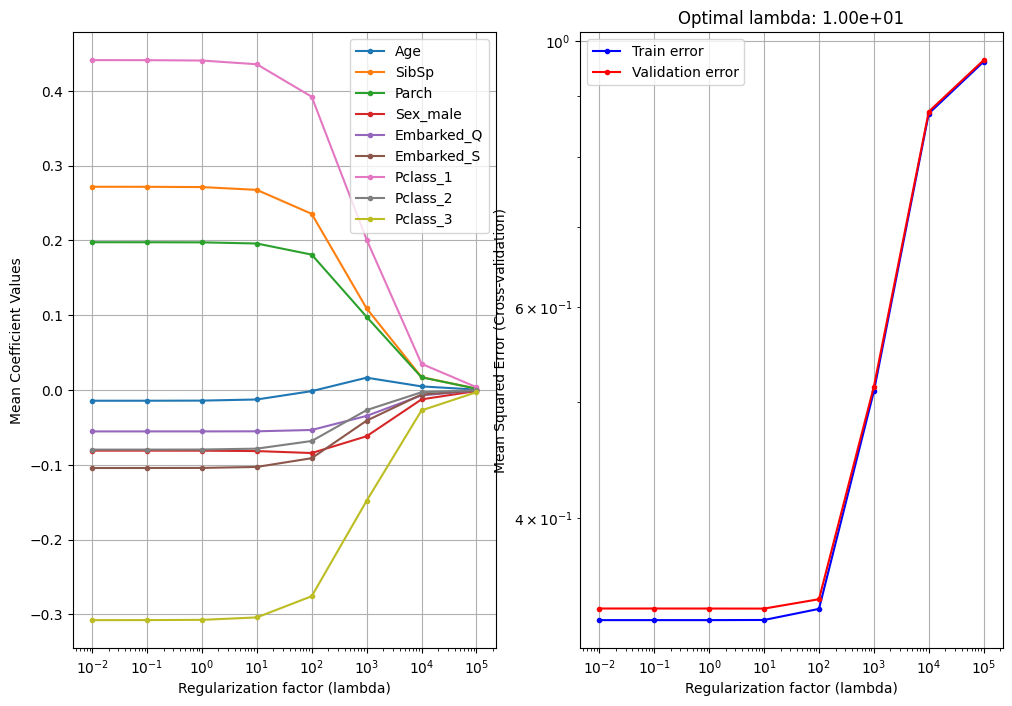

In [23]:
k = 0  # Cross-validation fold counter

# Perform outer cross-validation
for train_index, test_index in CV.split(X, y):
    # Extract training and test sets for the current fold
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]
    internal_cross_validation = 10  # Number of inner folds for lambda selection

    # Inner cross-validation to find the optimal lambda
    (
        opt_val_err,         # Minimum validation error across all tested lambdas
        opt_lambda,          # Lambda value with the minimum validation error
        mean_w_vs_lambda,    # Mean weight values across lambdas
        train_err_vs_lambda, # Training error for each lambda
        test_err_vs_lambda,  # Validation error for each lambda
    ) = rlr_validate(X_train, y_train, lambdas, internal_cross_validation)

    # Debug to identify attributes with unusually high coefficients
    avg_coefs = np.mean(np.abs(mean_w_vs_lambda), axis=1)  # Calculate mean coefficient magnitude across lambdas
    print(f"Cross-validation fold {k+1}:")
    for i, attribute_name in enumerate(attributeNames[1:]):  # Skip the bias term
        print(f"{attribute_name}: Average coefficient magnitude: {avg_coefs[i]:.4f}")
    print()

    # Precompute XtX and Xty for the training set
    Xty = X_train.T @ y_train
    XtX = X_train.T @ X_train

    # Regularized regression: Estimate weights for optimal lambda
    lambdaI = opt_lambda * np.eye(M)
    lambdaI[0, 0] = 0  # Do not regularize the bias term
    w_rlr[:, k] = np.linalg.solve(XtX + lambdaI, Xty).squeeze()

    # Compute errors with regularization
    Error_train_rlr[k] = np.mean(np.square(y_train - X_train @ w_rlr[:, k]))
    Error_test_rlr[k] = np.mean(np.square(y_test - X_test @ w_rlr[:, k]))

    # Unregularized regression: Estimate weights without regularization
    w_noreg[:, k] = np.linalg.solve(XtX, Xty).squeeze()

    # Compute errors without regularization
    Error_train[k] = np.mean(np.square(y_train - X_train @ w_noreg[:, k]))
    Error_test[k] = np.mean(np.square(y_test - X_test @ w_noreg[:, k]))

    # Visualization for the last cross-validation fold
    if k == K - 1:
        figure(figsize=(12, 8))

        # Plot mean weight values as a function of lambda
        subplot(1, 2, 1)
        semilogx(lambdas, mean_w_vs_lambda.T[:, 1:], ".-")  # Exclude bias term
        xlabel("Regularization factor (lambda)")
        ylabel("Mean Coefficient Values")
        grid()
        legend(attributeNames[1:], loc="best")  # Skip "Intercept" in legend

        # Plot train and validation errors as a function of lambda
        subplot(1, 2, 2)
        title(f"Optimal lambda: {opt_lambda:.2e}")
        loglog(
            lambdas, train_err_vs_lambda.T, "b.-",
            lambdas, test_err_vs_lambda.T, "r.-"
        )
        xlabel("Regularization factor (lambda)")
        ylabel("Mean Squared Error (Cross-validation)")
        legend(["Train error", "Validation error"])
        grid()

    k += 1  # Increment fold counter

In [24]:
# Display results for linear regression
print("Linear regression without regularization:")
print(f"- Average training error: {Error_train.mean():.4f}")
print(f"- Average test error:     {Error_test.mean():.4f}")

# Display results for regularized linear regression
print("\nRegularized linear regression:")
print(f"- Average training error: {Error_train_rlr.mean():.4f}")
print(f"- Average test error:     {Error_test_rlr.mean():.4f}")

# Display weights in the last fold
print("\nWeights in the last fold:")
print(f"{'Attribute':>20} {'Weight (w_rlr)':>20}")
print("-" * 40)
# Start from the second index to skip the bias term (Intercept)
for m in range(1, M):
    print(f"{attributeNames[m]:>20} {w_rlr[m, -1]:>20.2f}")

Linear regression without regularization:
- Average training error: 0.3296
- Average test error:     0.3391

Regularized linear regression:
- Average training error: 0.3296
- Average test error:     0.3390

Weights in the last fold:
           Attribute       Weight (w_rlr)
----------------------------------------
                 Age                -0.01
               SibSp                 0.27
               Parch                 0.20
            Sex_male                -0.08
          Embarked_Q                -0.06
          Embarked_S                -0.10
            Pclass_1                 0.44
            Pclass_2                -0.08
            Pclass_3                -0.30


In [41]:
# Parameters
outer_folds = 10
kf_outer = KFold(n_splits=outer_folds, shuffle=True, random_state=42)

# Define hyperparameter ranges
lambdas = np.power(10.0, range(-2, 6))  # Regularization parameters for Ridge
hidden_layer_sizes = [1, 3, 5, 10]  # Number of hidden units for ANN
max_iter = 2000
n_replicates = 1

# Initialize storage for results
results_table = []

# Outer Loop: For each fold in outer cross-validation
for i, (train_index_outer, test_index_outer) in enumerate(kf_outer.split(X, y)):
    print(f"\nOuter Fold {i + 1}/{outer_folds}")

    # Split data into outer training and testing sets
    X_train_outer, X_test_outer = X[train_index_outer], X[test_index_outer]
    y_train_outer, y_test_outer = y[train_index_outer], y[test_index_outer]

    # ===============================
    # 1. Baseline Model
    # ===============================
    baseline_model = DummyRegressor(strategy="mean")
    baseline_model.fit(X_train_outer, y_train_outer)
    baseline_predictions = baseline_model.predict(X_test_outer)
    baseline_error = np.mean((y_test_outer - baseline_predictions) ** 2)

    # ===============================
    # 2. Regularized Linear Regression
    # ===============================
    best_lambda = None
    best_ridge_error = float("inf")
    kf_inner = KFold(n_splits=5, shuffle=True, random_state=42)  # Inner folds

    for lambda_value in lambdas:
        inner_errors = []
        for train_index_inner, val_index_inner in kf_inner.split(X_train_outer):
            X_train_inner, X_val_inner = X_train_outer[train_index_inner], X_train_outer[val_index_inner]
            y_train_inner, y_val_inner = y_train_outer[train_index_inner], y_train_outer[val_index_inner]

            # Train Ridge Regression on inner training set
            ridge_model = Ridge(alpha=lambda_value)
            ridge_model.fit(X_train_inner, y_train_inner)
            val_predictions = ridge_model.predict(X_val_inner)
            inner_error = np.mean((y_val_inner - val_predictions) ** 2)
            inner_errors.append(inner_error)

        # Calculate mean error for this lambda
        mean_inner_error = np.mean(inner_errors)
        if mean_inner_error < best_ridge_error:
            best_ridge_error = mean_inner_error
            best_lambda = lambda_value

    # Train Ridge Regression on outer training set with best lambda
    ridge_model = Ridge(alpha=best_lambda)
    ridge_model.fit(X_train_outer, y_train_outer)
    ridge_predictions = ridge_model.predict(X_test_outer)
    ridge_error = np.mean((y_test_outer - ridge_predictions) ** 2)

    # ===============================
    # 3. Artificial Neural Network
    # ===============================
    best_hidden_layer = None
    best_ann_error = float("inf")

    for hidden_layer in hidden_layer_sizes:
        inner_errors = []
        for train_index_inner, val_index_inner in kf_inner.split(X_train_outer):
            X_train_inner = torch.Tensor(X_train_outer[train_index_inner])
            y_train_inner = torch.Tensor(y_train_outer[train_index_inner]).unsqueeze(1)
            X_val_inner = torch.Tensor(X_train_outer[val_index_inner])
            y_val_inner = torch.Tensor(y_train_outer[val_index_inner]).unsqueeze(1)

            # Define ANN model
            model = lambda: torch.nn.Sequential(
                torch.nn.Linear(X_train_inner.shape[1], hidden_layer),
                torch.nn.Tanh(),
                torch.nn.Linear(hidden_layer, 1),
            )
            loss_fn = torch.nn.MSELoss()

            # Train ANN
            net, _, _ = train_neural_net(
                model, loss_fn, X_train_inner, y_train_inner, max_iter=max_iter
            )

            # Validate ANN
            val_predictions = net(X_val_inner)
            inner_error = torch.mean((val_predictions - y_val_inner) ** 2).item()
            inner_errors.append(inner_error)

        # Calculate mean error for this hidden layer size
        mean_inner_error = np.mean(inner_errors)
        if mean_inner_error < best_ann_error:
            best_ann_error = mean_inner_error
            best_hidden_layer = hidden_layer

    # Train ANN on outer training set with best hidden layer size
    X_train_outer_tensor = torch.Tensor(X_train_outer)
    y_train_outer_tensor = torch.Tensor(y_train_outer).unsqueeze(1)
    X_test_outer_tensor = torch.Tensor(X_test_outer)
    net, _, _ = train_neural_net(
        lambda: torch.nn.Sequential(
            torch.nn.Linear(X_train_outer_tensor.shape[1], best_hidden_layer),
            torch.nn.Tanh(),
            torch.nn.Linear(best_hidden_layer, 1),
        ),
        torch.nn.MSELoss(),
        X_train_outer_tensor,
        y_train_outer_tensor,
        max_iter=max_iter,
    )
    ann_predictions = net(X_test_outer_tensor)
    ann_error = torch.mean((ann_predictions - torch.Tensor(y_test_outer).unsqueeze(1)) ** 2).item()

    # Append results for this fold
    results_table.append({
        "Outer Fold": i + 1,
        "Linear Regression (λ*)": best_lambda,
        "Linear Regression (E_test)": ridge_error,
        "ANN (hidden_layer*)": best_hidden_layer,
        "ANN (E_test)": ann_error,
        "Baseline (E_test)": baseline_error,
    })


Outer Fold 1/10

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.459466	0.001924348
		2000	0.5834811	0.00041293824
		Final loss:
		2000	0.5834811	0.00041293824

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.9272852	0.0012505823


/Users/ignacioripollgonzalez/Library/Mobile Documents/com~apple~CloudDocs/NACHO/DTU/2. MSc BUSINESS ANALYTICS/MScBA/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	0.51168334	0.0002494537
		Final loss:
		2000	0.51168334	0.0002494537

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.9506376	0.00087076623
		2000	0.51858795	0.00029173846
		Final loss:
		2000	0.51858795	0.00029173846

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.6440165	0.0017671554
		2000	0.5961508	0.0005356191
		Final loss:
		2000	0.5961508	0.0005356191

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.63071096	0.00076583965
		2000	0.40728438	0.00021559508
		Final loss:
		2000	0.40728438	0.00021559508

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.84170324	0.0010829224
		2000	0.47230616	0.00027428175
		Final loss:
		2000	0.47230616	0.00027428175

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.2994751	0.0011743143
		2000	0.6113669	0.0004199255
		Final loss:
		2000	0.6113669	0.0004199255

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	2.317316	0.0015183411
		2000	0.8323055	0.00063102134
		Final loss:
		2000	0.8323055	0.00063102134

	Replicate: 3/3
		Iter	Loss			Rel. l

/Users/ignacioripollgonzalez/Library/Mobile Documents/com~apple~CloudDocs/NACHO/DTU/2. MSc BUSINESS ANALYTICS/MScBA/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		2000	3.1780627	0.00052823743
		Final loss:
		2000	3.1780627	0.00052823743

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.52320415	0.0008807547
		2000	0.35570866	0.00013596125
		Final loss:
		2000	0.35570866	0.00013596125

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	3.3882823	0.0013675126
		2000	1.1132135	0.0007585549
		Final loss:
		2000	1.1132135	0.0007585549

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	1.9516053	0.001413042
		2000	0.80632687	0.00057950185
		Final loss:
		2000	0.80632687	0.00057950185

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	2.6648526	0.0018694183
		2000	0.72677785	0.00077990134
		Final loss:
		2000	0.72677785	0.00077990134

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	2.0688517	0.0014901598
		2000	0.772405	0.0006675169
		Final loss:
		2000	0.772405	0.0006675169

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.5613741	0.0008365
		2000	0.3635825	0.00021651397
		Final loss:
		2000	0.3635825	0.00021651397

	Replicate: 3/3
		Iter	Loss			Rel. loss
		10

/Users/ignacioripollgonzalez/Library/Mobile Documents/com~apple~CloudDocs/NACHO/DTU/2. MSc BUSINESS ANALYTICS/MScBA/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	1.2480524	0.001288571
		2000	0.5546572	0.0005829644
		Final loss:
		2000	0.5546572	0.0005829644

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	1.206793	0.0052474695
		2000	0.44975606	0.00048540803
		Final loss:
		2000	0.44975606	0.00048540803

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.7586995	0.00078068516
		2000	0.4346486	0.0002461616
		Final loss:
		2000	0.4346486	0.0002461616

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	2.8753123	0.0013860605
		2000	1.0237638	0.00073769887
		Final loss:
		2000	1.0237638	0.00073769887

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	1.0080748	0.0020329093
		2000	0.4528617	0.00033261903
		Final loss:
		2000	0.4528617	0.00033261903

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	2.295609	0.0027631854
		2000	0.62752175	0.000593299
		Final loss:
		2000	0.62752175	0.000593299

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	6.5961804	0.0011686445
		2000	0.92548656	0.00056700944
		Final loss:
		2000	0.92548656	0.00056700944

	Replicate: 3/3

/Users/ignacioripollgonzalez/Library/Mobile Documents/com~apple~CloudDocs/NACHO/DTU/2. MSc BUSINESS ANALYTICS/MScBA/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	1.8189504	0.0013921708
		2000	0.72216016	0.0005665402
		Final loss:
		2000	0.72216016	0.0005665402

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	2.0214825	0.0007049165
		2000	1.207207	0.00046074335
		Final loss:
		2000	1.207207	0.00046074335

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.2582707	0.0010544864
		2000	0.6203446	0.0004029063
		Final loss:
		2000	0.6203446	0.0004029063

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	1.3647578	0.0030952727
		2000	0.4968141	0.00035691442
		Final loss:
		2000	0.4968141	0.00035691442

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	1.6252886	0.0008249808
		2000	1.0506282	0.00031771386
		Final loss:
		2000	1.0506282	0.00031771386

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	2.9536128	0.0014760616
		2000	0.99750763	0.00071861746
		Final loss:
		2000	0.99750763	0.00071861746

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	6.1259594	0.00054208655
		2000	3.4561496	0.00061151275
		Final loss:
		2000	3.4561496	0.00061151275

	Replicate: 

/Users/ignacioripollgonzalez/Library/Mobile Documents/com~apple~CloudDocs/NACHO/DTU/2. MSc BUSINESS ANALYTICS/MScBA/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	2.332363	0.0016443931
		2000	0.7676934	0.0006634695
		Final loss:
		2000	0.7676934	0.0006634695

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	3.7263467	0.0016558552
		2000	0.7199498	0.00072719494
		Final loss:
		2000	0.7199498	0.00072719494

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	3.2895408	0.0014429766
		2000	1.0366218	0.0007928561
		Final loss:
		2000	1.0366218	0.0007928561

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.6483073	0.0006563802
		2000	0.39189863	0.00015108057
		Final loss:
		2000	0.39189863	0.00015108057

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.90514207	0.001414389
		2000	0.43985784	0.0003183445
		Final loss:
		2000	0.43985784	0.0003183445

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.5551172	0.0009084691
		2000	0.49939668	0.00041803916
		Final loss:
		2000	0.49939668	0.00041803916

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	1.0542479	0.0019630818
		2000	0.4613503	0.0003659431
		Final loss:
		2000	0.4613503	0.0003659431

	Replicate: 3/

/Users/ignacioripollgonzalez/Library/Mobile Documents/com~apple~CloudDocs/NACHO/DTU/2. MSc BUSINESS ANALYTICS/MScBA/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.7256449	0.00074002834
		2000	0.4763356	0.00019260302
		Final loss:
		2000	0.4763356	0.00019260302

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	4.0611253	0.0006139383
		2000	2.6395497	0.00085726613
		Final loss:
		2000	2.6395497	0.00085726613

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.6271757	0.0016527534
		2000	0.63534665	0.00059967686
		Final loss:
		2000	0.63534665	0.00059967686

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.7978399	0.0012974782
		2000	0.4447056	0.00022324694
		Final loss:
		2000	0.4447056	0.00022324694

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	1.4437053	0.001903036
		2000	0.53997093	0.0016872517
		Final loss:
		2000	0.53997093	0.0016872517

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.2328261	0.0013058152
		2000	0.5569112	0.0004666348
		Final loss:
		2000	0.5569112	0.0004666348

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	1.4397949	0.0020569672
		2000	0.46129575	0.00040704382
		Final loss:
		2000	0.46129575	0.00040704382

	Replicat

/Users/ignacioripollgonzalez/Library/Mobile Documents/com~apple~CloudDocs/NACHO/DTU/2. MSc BUSINESS ANALYTICS/MScBA/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	1.4637861	0.0013040901
		2000	0.6589509	0.00047971786
		Final loss:
		2000	0.6589509	0.00047971786

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	8.687924	0.0004865935
		2000	5.2976384	0.00052879535
		Final loss:
		2000	5.2976384	0.00052879535

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	2.021111	0.0009623679
		2000	1.2245752	0.0003700754
		Final loss:
		2000	1.2245752	0.0003700754

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	3.0994387	0.0011076957
		2000	0.551744	0.0005252876
		Final loss:
		2000	0.551744	0.0005252876

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	1.8853539	0.00040102794
		2000	1.1277624	0.0007345275
		Final loss:
		2000	1.1277624	0.0007345275

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.6834322	0.0007568776
		2000	0.43011588	0.00025817365
		Final loss:
		2000	0.43011588	0.00025817365

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	1.049246	0.0011538967
		2000	0.5097677	0.00043629098
		Final loss:
		2000	0.5097677	0.00043629098

	Replicate: 3/3
		I

/Users/ignacioripollgonzalez/Library/Mobile Documents/com~apple~CloudDocs/NACHO/DTU/2. MSc BUSINESS ANALYTICS/MScBA/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	2.0737414	0.0013767104
		2000	0.8495942	0.000573692
		Final loss:
		2000	0.8495942	0.000573692

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.82124984	0.0006532102
		2000	0.51348144	0.00020437414
		Final loss:
		2000	0.51348144	0.00020437414

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	2.9432275	0.0010458244
		2000	1.6182642	0.000398074
		Final loss:
		2000	1.6182642	0.000398074

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	1.2126089	0.0010267559
		2000	0.6414635	0.000350092
		Final loss:
		2000	0.6414635	0.000350092

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	2.1675925	0.0010982759
		2000	1.2222717	0.00037155225
		Final loss:
		2000	1.2222717	0.00037155225

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.8105552	0.0014231065
		2000	0.6828652	0.00026327284
		Final loss:
		2000	0.6828652	0.00026327284

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.86704	0.0010419121
		2000	0.48665455	0.00029410646
		Final loss:
		2000	0.48665455	0.00029410646

	Replicate: 3/3
		It

/Users/ignacioripollgonzalez/Library/Mobile Documents/com~apple~CloudDocs/NACHO/DTU/2. MSc BUSINESS ANALYTICS/MScBA/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	0.70984167	0.0006797699
		2000	0.4426522	0.00020570814
		Final loss:
		2000	0.4426522	0.00020570814

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	0.76712996	0.0009968837
		2000	0.4507625	0.00025936935
		Final loss:
		2000	0.4507625	0.00025936935

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	1.4847187	0.0011196851
		2000	0.6572342	0.0005644992
		Final loss:
		2000	0.6572342	0.0005644992

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	1.1995058	0.0017258655
		2000	0.5124895	0.00040910678
		Final loss:
		2000	0.5124895	0.00040910678

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	1.9120787	0.0013656162
		2000	0.79484385	0.00055955554
		Final loss:
		2000	0.79484385	0.00055955554

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	0.4730052	0.0005953702
		2000	0.35411558	0.00011595886
		Final loss:
		2000	0.35411558	0.00011595886

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	4.624549	0.0010598772
		2000	2.530822	0.00034288637
		Final loss:
		2000	2.530822	0.00034288637

	Replicate

/Users/ignacioripollgonzalez/Library/Mobile Documents/com~apple~CloudDocs/NACHO/DTU/2. MSc BUSINESS ANALYTICS/MScBA/lib/python3.12/site-packages/dtuimldmtools/models/nn_trainer.py:141: RuntimeWarning: overflow encountered in cast
  if loss_value < best_final_loss:


		1000	2.0952537	0.0012955236
		2000	1.0428853	0.0006641406
		Final loss:
		2000	1.0428853	0.0006641406

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	1.573729	0.0006510221
		2000	0.70942545	0.0064787404
		Final loss:
		2000	0.70942545	0.0064787404

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	5.1700945	0.00067761453
		2000	3.0438461	0.0004998747
		Final loss:
		2000	3.0438461	0.0004998747

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.7400593	0.0008506679
		2000	0.44301146	0.00032649952
		Final loss:
		2000	0.44301146	0.00032649952

	Replicate: 3/3
		Iter	Loss			Rel. loss
		1000	2.7758906	0.0009861493
		2000	1.6377174	0.00034090443
		Final loss:
		2000	1.6377174	0.00034090443

	Replicate: 1/3
		Iter	Loss			Rel. loss
		1000	2.8719451	0.0015259999
		2000	0.9764407	0.0006747385
		Final loss:
		2000	0.9764407	0.0006747385

	Replicate: 2/3
		Iter	Loss			Rel. loss
		1000	0.9266281	0.0010368597
		2000	0.45766878	0.00045398952
		Final loss:
		2000	0.45766878	0.00045398952

	Replicate: 3


Two-level Cross-Validation Table:
   Outer Fold  Linear Regression (λ*)  Linear Regression (E_test)  \
0           1                     1.0                    0.326729   
1           2                     1.0                    0.590123   
2           3                     1.0                    0.547920   
3           4                    10.0                    0.198994   
4           5                    10.0                    0.262458   
5           6                    10.0                    0.300604   
6           7                     1.0                    0.214872   
7           8                     1.0                    0.180211   
8           9                    10.0                    0.425634   
9          10                     1.0                    0.344449   

   ANN (hidden_layer*)  ANN (E_test)  Baseline (E_test)  
0                   10      0.284093           0.996884  
1                   10      0.474406           1.027670  
2                   10      0.5

/var/folders/0f/zds9whdd02q1swd8qb96m5m00000gn/T/ipykernel_82411/248787952.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


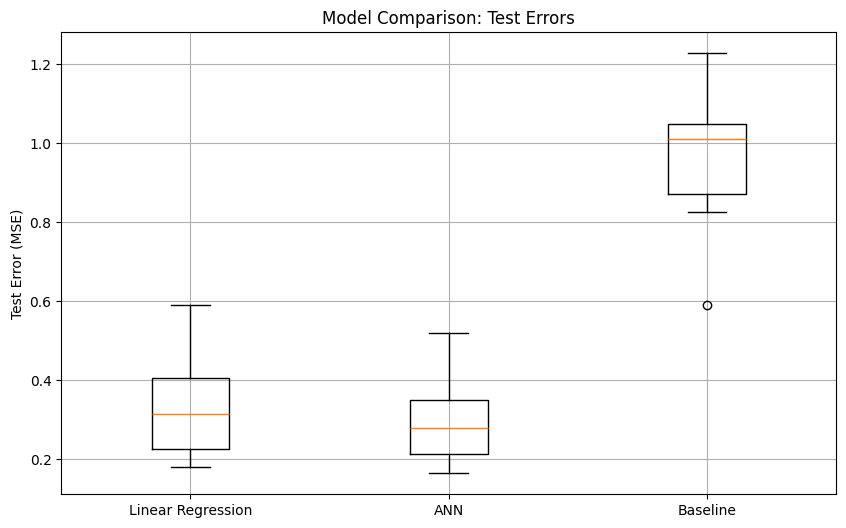

In [42]:
# Convert results into a DataFrame
results_df = pd.DataFrame(results_table)

# Display the table
print("\nTwo-level Cross-Validation Table:")
print(results_df)

# Visualize Test Errors for Each Model
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.boxplot(
    [
        results_df["Linear Regression (E_test)"],
        results_df["ANN (E_test)"],
        results_df["Baseline (E_test)"],
    ],
    labels=["Linear Regression", "ANN", "Baseline"],
)
plt.ylabel("Test Error (MSE)")
plt.title("Model Comparison: Test Errors")
plt.grid()
plt.show()

In [43]:
# Extract test errors from the results table
ridge_errors = results_df["Linear Regression (E_test)"]
ann_errors = results_df["ANN (E_test)"]
baseline_errors = results_df["Baseline (E_test)"]

# Pairwise t-tests
print("Paired t-tests:")
ann_vs_ridge_t, ann_vs_ridge_p = ttest_rel(ann_errors, ridge_errors)
print(f"ANN vs. Linear Regression: t={ann_vs_ridge_t:.4f}, p={ann_vs_ridge_p:.4f}")

ann_vs_baseline_t, ann_vs_baseline_p = ttest_rel(ann_errors, baseline_errors)
print(f"ANN vs. Baseline: t={ann_vs_baseline_t:.4f}, p={ann_vs_baseline_p:.4f}")

ridge_vs_baseline_t, ridge_vs_baseline_p = ttest_rel(ridge_errors, baseline_errors)
print(f"Linear Regression vs. Baseline: t={ridge_vs_baseline_t:.4f}, p={ridge_vs_baseline_p:.4f}")

# Interpret results
alpha = 0.05
print("\nInterpretation:")
print(f"ANN vs. Linear Regression: {'Significant' if ann_vs_ridge_p < alpha else 'Not significant'}")
print(f"ANN vs. Baseline: {'Significant' if ann_vs_baseline_p < alpha else 'Not significant'}")
print(f"Linear Regression vs. Baseline: {'Significant' if ridge_vs_baseline_p < alpha else 'Not significant'}")

Paired t-tests:
ANN vs. Linear Regression: t=-3.2983, p=0.0093
ANN vs. Baseline: t=-12.8518, p=0.0000
Linear Regression vs. Baseline: t=-11.4606, p=0.0000

Interpretation:
ANN vs. Linear Regression: Significant
ANN vs. Baseline: Significant
Linear Regression vs. Baseline: Significant


In [44]:
# Calculate differences between test errors
diff_ann_vs_ridge = ann_errors - ridge_errors
diff_ann_vs_baseline = ann_errors - baseline_errors
diff_ridge_vs_baseline = ridge_errors - baseline_errors

# Compute mean and standard error of differences
mean_diff_ann_ridge = np.mean(diff_ann_vs_ridge)
se_diff_ann_ridge = np.std(diff_ann_vs_ridge, ddof=1) / np.sqrt(len(diff_ann_vs_ridge))

mean_diff_ann_baseline = np.mean(diff_ann_vs_baseline)
se_diff_ann_baseline = np.std(diff_ann_vs_baseline, ddof=1) / np.sqrt(len(diff_ann_vs_baseline))

mean_diff_ridge_baseline = np.mean(diff_ridge_vs_baseline)
se_diff_ridge_baseline = np.std(diff_ridge_vs_baseline, ddof=1) / np.sqrt(len(diff_ridge_vs_baseline))

# Compute 95% confidence intervals
ci_ann_ridge = (mean_diff_ann_ridge - 1.96 * se_diff_ann_ridge, mean_diff_ann_ridge + 1.96 * se_diff_ann_ridge)
ci_ann_baseline = (mean_diff_ann_baseline - 1.96 * se_diff_ann_baseline, mean_diff_ann_baseline + 1.96 * se_diff_ann_baseline)
ci_ridge_baseline = (mean_diff_ridge_baseline - 1.96 * se_diff_ridge_baseline, mean_diff_ridge_baseline + 1.96 * se_diff_ridge_baseline)

# Print results
print("\nConfidence Intervals (Setup II):")
print(f"ANN vs. Linear Regression: mean={mean_diff_ann_ridge:.4f}, 95% CI={ci_ann_ridge}")
print(f"ANN vs. Baseline: mean={mean_diff_ann_baseline:.4f}, 95% CI={ci_ann_baseline}")
print(f"Linear Regression vs. Baseline: mean={mean_diff_ridge_baseline:.4f}, 95% CI={ci_ridge_baseline}")


Confidence Intervals (Setup II):
ANN vs. Linear Regression: mean=-0.0388, 95% CI=(np.float64(-0.061880591951768996), np.float64(-0.01574966722675866))
ANN vs. Baseline: mean=-0.6655, 95% CI=(np.float64(-0.7670279094036759), np.float64(-0.5640310863058658))
Linear Regression vs. Baseline: mean=-0.6267, 95% CI=(np.float64(-0.7338953611727926), np.float64(-0.5195333753582217))
